In [2]:
""" RNN dam flow prediction: stacked RNN """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data_hr - data_hr.csv', encoding='utf-8')

In [4]:
data = data.fillna(0)
data = data[26280:]
data = data.reset_index(drop=True, inplace=False)

In [5]:
original_dam = data['dam']

In [6]:
dam = data.drop(['date','90','100','101','211','212'], axis = 1)

In [7]:
print(data)

                    date      dam   90  100  101  211  212
0        2000-01-01 0:00   13.100  0.1  0.0  0.0  0.0  0.0
1        2000-01-01 1:00    0.000  0.0  0.0  0.0  0.0  0.0
2        2000-01-01 2:00    0.000  0.0  0.0  0.0  0.0  0.0
3        2000-01-01 3:00  143.400  0.7  0.0  0.0  0.0  0.0
4        2000-01-01 4:00    0.000  0.0  0.0  0.0  0.0  0.0
...                  ...      ...  ...  ...  ...  ...  ...
210379  2023-12-31 19:00  173.106  0.0  0.0  0.0  0.0  0.0
210380  2023-12-31 20:00    0.000  0.0  0.0  0.0  0.0  0.0
210381  2023-12-31 21:00  124.118  0.0  0.0  0.0  0.0  0.0
210382  2023-12-31 22:00   15.417  0.0  0.0  0.0  0.0  0.0
210383  2023-12-31 23:00    0.000  0.0  0.0  0.0  0.0  0.0

[210384 rows x 7 columns]


In [8]:
dates = pd.to_datetime(data['date'])

In [9]:
# variables for training
cols = list(data)[1:7]

In [10]:
print(cols)

['dam', '90', '100', '101', '211', '212']


In [11]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range = (0,1))
dam_data_scaled = scaler.fit_transform(data)

scaler_dam = MinMaxScaler(feature_range=(0,1))
dam_scaled = scaler_dam.fit_transform(dam)

In [13]:
# scaler = StandardScaler()
# dam_data_scaled = scaler.fit_transform(data)

# scaler_dam = StandardScaler()
# dam_scaled = scaler_dam.fit_transform(dam)

In [14]:
print(dam_data_scaled)

[[0.00123644 0.0011274  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 ...
 [0.01171487 0.         0.         0.         0.         0.        ]
 [0.00145513 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [15]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

189345   2021-08-07 09:00:00
189346   2021-08-07 10:00:00
189347   2021-08-07 11:00:00
189348   2021-08-07 12:00:00
189349   2021-08-07 13:00:00
Name: date, dtype: datetime64[ns]


In [16]:
print(train_data_scaled)

[[1.23644255e-03 1.12739572e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.71924637e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.71924637e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.71924637e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [17]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 24   # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['dam', '90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

print(trainX[1][-1])
print(trainY[0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

[0.00846633 0.         0.         0.         0.         0.        ]
[0.00846633]


In [18]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(189321, 24, 6) (189321, 1)
(21015, 24, 6) (21015, 1)


In [19]:
print(data)

            dam   90  100  101  211  212
0        13.100  0.1  0.0  0.0  0.0  0.0
1         0.000  0.0  0.0  0.0  0.0  0.0
2         0.000  0.0  0.0  0.0  0.0  0.0
3       143.400  0.7  0.0  0.0  0.0  0.0
4         0.000  0.0  0.0  0.0  0.0  0.0
...         ...  ...  ...  ...  ...  ...
210379  173.106  0.0  0.0  0.0  0.0  0.0
210380    0.000  0.0  0.0  0.0  0.0  0.0
210381  124.118  0.0  0.0  0.0  0.0  0.0
210382   15.417  0.0  0.0  0.0  0.0  0.0
210383    0.000  0.0  0.0  0.0  0.0  0.0

[210384 rows x 6 columns]


In [20]:
# RNN model
model = Sequential()
model.add(Flatten(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(64, activation ='relu'))
model.add(Dense(32))
model.add(Dense(trainY.shape[1]))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 64)                9280      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11393 (44.50 KB)
Trainable params: 11393 (44.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30
5325/5325 [==============================] - 6s 1ms/step - loss: 1.5075e-04 - val_loss: 1.4280e-04
Epoch 2/30
5325/5325 [==============================] - 5s 1ms/step - loss: 1.6296e-04 - val_loss: 1.3122e-04
Epoch 3/30
5325/5325 [==============================] - 5s 1ms/step - loss: 1.3969e-04 - val_loss: 1.2564e-04
Epoch 4/30
5325/5325 [==============================] - 6s 1ms/step - loss: 1.6480e-04 - val_loss: 1.3385e-04
Epoch 5/30
5325/5325 [==============================] - 6s 1ms/step - loss: 1.4959e-04 - val_loss: 1.3283e-04
Epoch 6/30
5325/5325 [==============================] - 6s 1ms/step - loss: 1.6513e-04 - val_loss: 1.2631e-04
Epoch 7/30
5325/5325 [==============================] - 6s 1ms/step - loss: 1.4099e-04 - val_loss: 1.2918e-04
Epoch 8/30
5325/5325 [==============================] - 6s 1ms/step - loss: 1.4609e-04 - val_loss: 1.5463e-04
Epoch 9/30
5325/5325 [==============================] - 6s 1ms/step - loss

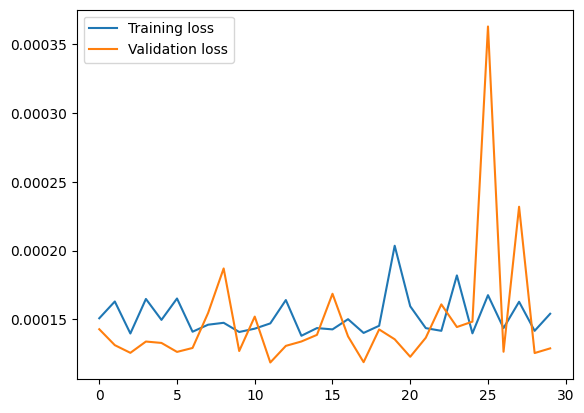

In [36]:
# Try to load weights
try:
    model.load_weights('1hr_dam_rnn_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('hr_dam_rnn_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

657/657 [==============================] - 1s 916us/step
[[0.00318798]
 [0.00356734]
 [0.00415283]
 ...
 [0.01118964]
 [0.00883475]
 [0.00585332]]


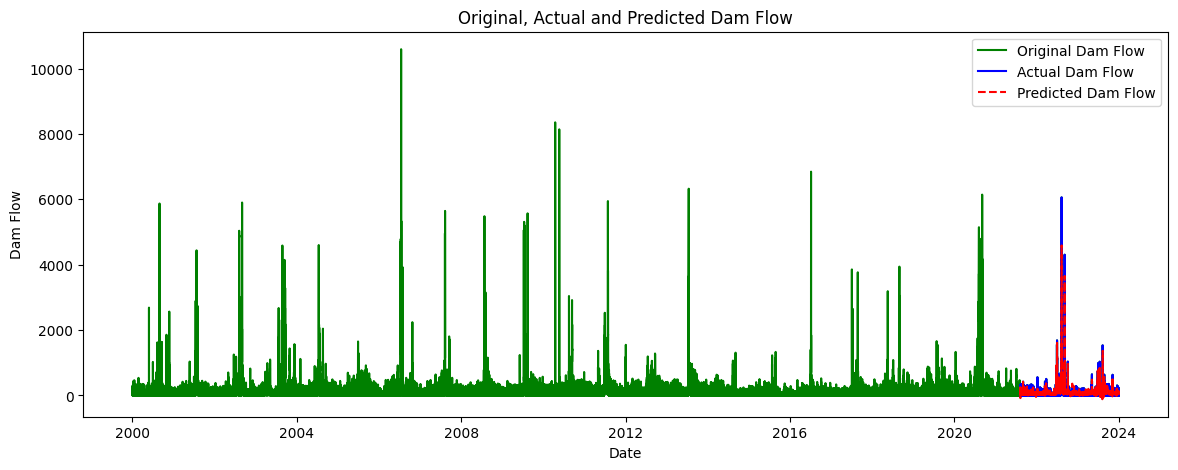

In [37]:
prediction = model.predict(testX)
print(prediction)

y_pred = scaler_dam.inverse_transform(prediction)[:,0]
testY_original = scaler_dam.inverse_transform(testY)[:,0]

# mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
# mean_values_pred[:, 0] = np.squeeze(prediction)
# y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
# print(y_pred.shape)

# mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis = 0)
# mean_values_testY[:, 0] = np.squeeze(testY)
# testY_original = scaler.inverse_transform(mean_values_testY)[:, 0]
# print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [38]:
testDates = pd.DataFrame(test_dates[24:])
testDates = testDates.reset_index(drop=True)

pred_y = pd.DataFrame(y_pred)
original_y = pd.DataFrame(testY_original)

print(len(testDates), len(pred_y), len(original_y))

rnn_include_dam = pd.concat([testDates, original_y, pred_y], axis = 1)
print(rnn_include_dam)

rnn_include_dam = pd.DataFrame(rnn_include_dam)
rnn_include_dam.to_csv("./data/hr_rnn_include_dam.csv")

21015 21015 21015
                     date        0           0
0     2021-08-08 09:00:00    0.500   33.776333
1     2021-08-08 10:00:00   68.522   37.795631
2     2021-08-08 11:00:00   71.548   43.998837
3     2021-08-08 12:00:00    0.000   61.068680
4     2021-08-08 13:00:00   71.713   74.741333
...                   ...      ...         ...
21010 2023-12-31 19:00:00  173.106   70.668991
21011 2023-12-31 20:00:00    0.000   88.820686
21012 2023-12-31 21:00:00  124.118  118.553284
21013 2023-12-31 22:00:00   15.417   93.603355
21014 2023-12-31 23:00:00    0.000   62.015385

[21015 rows x 3 columns]


In [39]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

rnn_include_x = pd.concat([testDates, testX_last, original_y, pred_y], axis = 1)
rnn_include_x.to_csv("./data/hr_rnn_include_x.csv")

print(rnn_include_x)

[4.71924637e-05 4.50958286e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
                     date        0    1    2    3    4    5        0  \
0     2021-08-08 09:00:00    0.500  4.0  0.0  0.0  0.0  0.0    0.500   
1     2021-08-08 10:00:00    0.500  0.2  0.0  0.0  0.0  0.0   68.522   
2     2021-08-08 11:00:00   68.522  0.0  0.0  0.0  0.0  0.0   71.548   
3     2021-08-08 12:00:00   71.548  0.0  0.0  0.0  0.0  0.0    0.000   
4     2021-08-08 13:00:00    0.000  2.3  0.0  0.0  0.0  0.0   71.713   
...                   ...      ...  ...  ...  ...  ...  ...      ...   
21010 2023-12-31 19:00:00   21.177  1.6  0.0  0.0  0.0  0.0  173.106   
21011 2023-12-31 20:00:00  173.106  0.0  0.0  0.0  0.0  0.0    0.000   
21012 2023-12-31 21:00:00    0.000  0.0  0.0  0.0  0.0  0.0  124.118   
21013 2023-12-31 22:00:00  124.118  0.0  0.0  0.0  0.0  0.0   15.417   
21014 2023-12-31 23:00:00   15.417  0.0  0.0  0.0  0.0  0.0    0.000   

                0  
0       33.776333  
1 

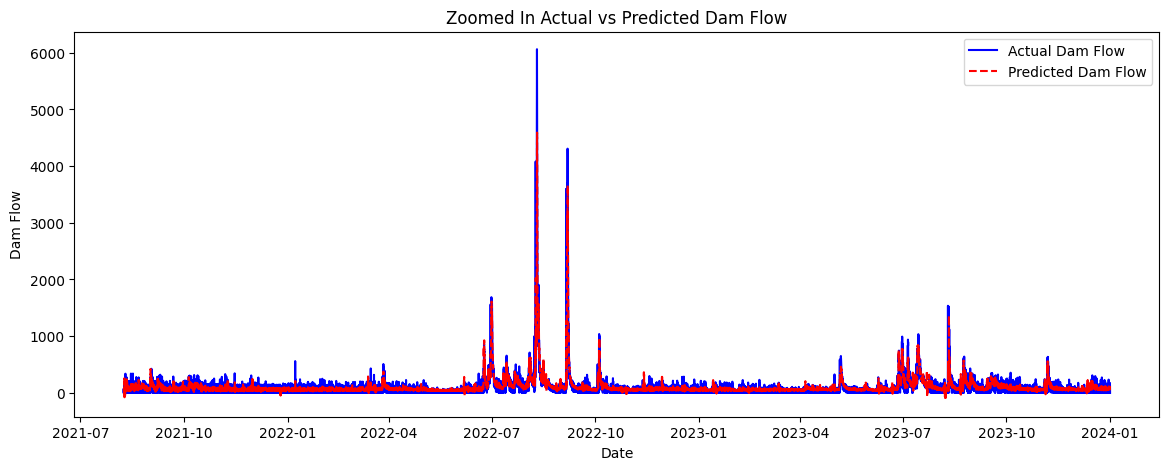

In [40]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 21015
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

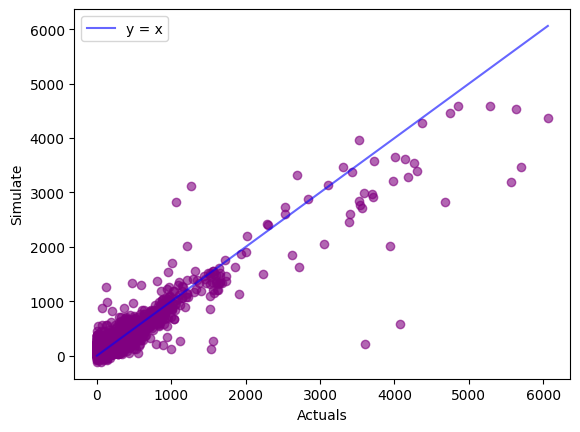

In [43]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [44]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 89.80


In [45]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.826300


In [46]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : -30.491529


In [47]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.833760
